# Lab 1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower, P. Ablin, M. Massias

## Aim

The aim of this material is to code
- proximal gradient descent (PGD)
- accelerated gradient descent (APGD)

for
- linear regression
- logistic regression

models.

The proximal operators we will use are the
- L2 penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work using the **moodle platform**. Please check the deadline on moodle!
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [25]:
# Change here using YOUR first and last names
fn1 = "ralph"
ln1 = "mouawad"
fn2 = "charles"
ln2 = "karrer"

filename = "_".join(map(lambda s: s.strip().lower(),
                        ["lab1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab1_mouawad_ralph_and_karrer_charles.ipynb


In [26]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [56]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

Text(0.5, 1.0, 'Parameters / Coefficients')

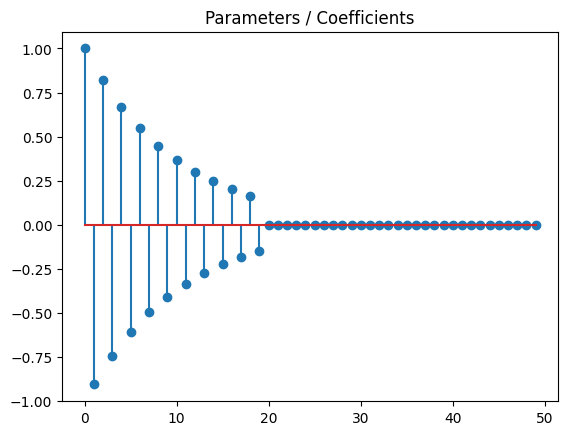

In [57]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [58]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model

    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model

    n_samples : `int`, default=1000
        Number of samples to simulate

    corr : `float`, default=0.5
         Correlation between features i and j is corr^|i - j|


    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian
        vector with covariance given by the Toeplitz matrix

    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + np.random.randn(n_samples)
    return A, b


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model

    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model

    n_samples : `int`, default=1000
        Number of samples to simulate

    corr : `float`, default=0.5
        Correlation between features i and j is corr^|i - j|

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian
        vector with covariance given by the Toeplitz matrix

    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

/tmp/ipython-input-1662604985.py:2: DeprecationWarning: Please import `toeplitz` from the `scipy.linalg` namespace; the `scipy.linalg.special_matrices` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.linalg.special_matrices import toeplitz


## Generate the data

In [30]:
# A, b = simu_linreg(coefs)
A, b = simu_logreg(coefs)  # uncomment when you want to test logistic regression

## Part 1 : Proximal operators

We remind that the proximal operator of a function $R$ is given by:

$$
\text{prox}_{(\lambda \,R)}(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + \lambda \,R(z) \right\}.
$$


We have in mind to use the following cases

- L2 penalization, where $R(z) = \frac{1}{2} \|z\|_2^2$
- L1 penalization, where $R(z) =  \|z|\|_1$

where $\lambda > 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $R(x)$ in both cases and $\text{prox}_{\lambda\, R}(x)$ for L2 and  L1 penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
      <li>Visualize the functions applied element wise by the proximity operators of the L2 and L1
    </li>
    </ul>
</div>

In [31]:
def prox_L1(x, lmbd):
    """Proximal operator for the L1 at x"""
    return np.sign(x) * np.maximum(np.abs(x)-lmbd, 0) # TODO

def L1_norm(x, lmbd):
    """Value of the L1 penalization at x"""
    return lmbd*np.linalg.norm(x, 1) # TODO

def prox_L2(x, lmbd):
    """Proximal operator for the L2 at x"""
    return (1/(1+lmbd))*x # TODO

def L2_norm(x, lmbd):
    """Value of the L2 penalization at x"""
    return lmbd*np.linalg.norm(x,2) # TODO

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2.0, 2.0)

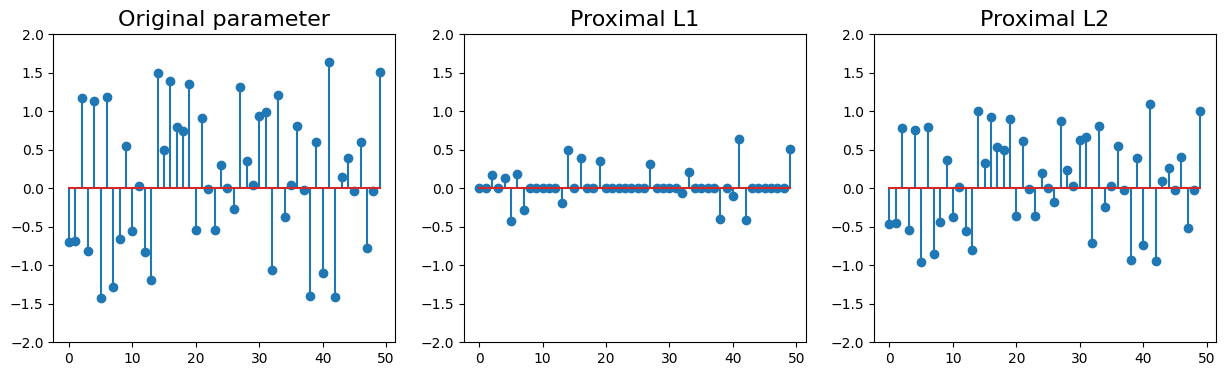

In [32]:
x = np.random.randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_L1(x, lmbd=l_l1))
plt.title("Proximal L1", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_L2(x, lmbd=l_l2))
plt.title("Proximal L2", fontsize=16)
plt.ylim([-2, 2])

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

Both proximal methods are shrinking the weights, which is expected. We can notice two differences among these two:
- The proximal L2 shrinks the weights and makes them smaller, but they are all different than zero.
- The proximal L1 shrinks the weights but makes many of them exactly equal to zero. This is due to the fact that the constraint is a square along the axis, and attracts many coordinates to one of them (making the solution sparse).

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + \lambda \,R(x)
$$
where $f$ is $L$-smooth and $R$ has a simple proximal operator.

Consider the following cases:

**Linear regression**, where
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A = [a_1,\ldots, a_n]^{\top} \in \mathbb{R}^{n \times d}$ is the matrix of samples.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

In [33]:
def loss_linreg(x):
    """Least-squares loss"""
    return 1 / (2*n_samples) * np.linalg.norm(b - A @ x, 2)**2
    pass

def grad_linreg(x):
    """Leas-squares gradient"""
    return 1/n_samples * (A.T @ (A @ x) - A.T @ b)
    pass

def loss_logreg(x):
    """Logistic loss"""
    loss= 0
    for i in range(n_samples):
      loss += np.log(1 + np.exp(-b[i] * (A[i,:].T @ x)))
    return 1/n_samples * loss
    pass

def grad_logreg(x):
    """Logistic gradient"""
    grad=0
    for i in range(n_samples):
      b_i = b[i]
      a_i = A[i,:]
      grad += (b_i * a_i) / (1 + np.exp(b_i * (a_i.T @ x)))
    return (-1/n_samples)*grad

    pass

# TO BE COMPLETED

In [34]:
## check grad for linear regression
from scipy.optimize import check_grad

A, b = simu_linreg(coefs)
check_grad(loss_linreg, grad_linreg, x0=coefs)

np.float64(6.444738722536018e-08)

In [35]:
## check grad for logistic regression - we commented the initialization before for lin_reg and uncommented for log_reg
A, b = simu_logreg(coefs)  # uncomment when you want to test logistic regression

check_grad(loss_logreg, grad_logreg, x0=coefs)

np.float64(2.28583747655445e-07)

The gradient difference between our results and SciPy is very low, which indicates that we computed them correctly.

## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $R$ and $\text{prox}_R$.

We want now to code the PGD and APGD solvers to minimize

$$
\arg\min_x f(x) + \lambda \, R(x)
$$

where $\lambda >0$ is the regularization parameter

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Implement functions that compute the Lipschitz constants for linear and
  logistic regression losses. Note that the operator norm of a matrix can
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (read the documentation
  of the function)</li>
      <li>Finish the functions `PGD` and `APGD` below that implements the
  PGD(Proximal Gradient Descent) and APGD (Accelerated Proximal
  Gradient Descent) algorithms</li>
    </ul>
</div>

In [74]:
# TO BE COMPLETED

# Calculate the smoothness constant for L2
def smoothness_const_linreg(A):
    """Lipschitz constant for linear squares loss"""
    return np.linalg.norm(A.T @ A, 2)
    pass
# Calculate the smoothness constant for Logistic loss
def smoothness_const_loreg(A):
    """Lipschitz constant for logistic loss"""
    return 1/(4*n_samples) * np.linalg.norm(A.T @ A, 2)
    pass

def PGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    if verbose:
        print("Lauching PGDsolver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####

        x_new = prox_R(x - step*grad_f(x), lmbd)
        x = x_new.copy()

        obj = f(x) + R(x, lmbd)
        err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8),
                              ("%.2e" % obj).rjust(8),
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [75]:
# TO BE COMPLETED

def APGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for APGD
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    t = 1.
    t_new = 1.
    if verbose:
        print("Lauching APGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):


        #### TODO ####
        x_new = prox_R(z - step*grad_f(z), lmbd)
        t_new = (1 + np.sqrt(1+4*t**2)) / 2
        z = x_new + ((t-1)/t_new)*(x_new - x)

        x = x_new.copy()
        t = t_new

        obj = f(x) + R(x, lmbd)
        err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8),
                              ("%.2e" % obj).rjust(8),
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [76]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 200
lmbd = 1e-2

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the linear regression with L2
  penalization problem using the parameters give above. This can be done by using APGD with
  1000 iterations.</li>
    <li>Compare the convergences of PGD and APGD, in terms of distance to the minimum and
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

In [77]:
A, b = simu_linreg(coefs)
step = 1/smoothness_const_linreg(A)

In [78]:
## PGD
x_apgd, obj_apgd, err_apgd = APGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, step=step, lmbd=lmbd, n_iter=1000)

Lauching APGD solver...
   it    |   obj    |   err   
       0 | 1.53e+00 | 1.00e+00
      10 | 1.52e+00 | 9.98e-01
      20 | 1.51e+00 | 9.94e-01
      30 | 1.50e+00 | 9.90e-01
      40 | 1.50e+00 | 9.88e-01
      50 | 1.49e+00 | 9.88e-01
      60 | 1.50e+00 | 9.88e-01
      70 | 1.50e+00 | 9.89e-01
      80 | 1.50e+00 | 9.89e-01
      90 | 1.50e+00 | 9.89e-01
     100 | 1.50e+00 | 9.89e-01
     110 | 1.50e+00 | 9.89e-01
     120 | 1.50e+00 | 9.89e-01
     130 | 1.50e+00 | 9.89e-01
     140 | 1.50e+00 | 9.89e-01
     150 | 1.50e+00 | 9.89e-01
     160 | 1.50e+00 | 9.89e-01
     170 | 1.50e+00 | 9.89e-01
     180 | 1.50e+00 | 9.89e-01
     190 | 1.50e+00 | 9.89e-01
     200 | 1.50e+00 | 9.89e-01
     210 | 1.50e+00 | 9.89e-01
     220 | 1.50e+00 | 9.89e-01
     230 | 1.50e+00 | 9.89e-01
     240 | 1.50e+00 | 9.89e-01
     250 | 1.50e+00 | 9.89e-01
     260 | 1.50e+00 | 9.89e-01
     270 | 1.50e+00 | 9.89e-01
     280 | 1.50e+00 | 9.89e-01
     290 | 1.50e+00 | 9.89e-01
     300 | 1.50

In [67]:
x_pgd, obj_pgd, err_pgd = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, step=step, lmbd=lmbd, n_iter=1000)

Lauching PGDsolver...
   it    |   obj    |   err   
       0 | 1.51e+00 | 1.00e+00
      10 | 1.51e+00 | 9.99e-01
      20 | 1.51e+00 | 9.98e-01
      30 | 1.50e+00 | 9.97e-01
      40 | 1.50e+00 | 9.96e-01
      50 | 1.50e+00 | 9.95e-01
      60 | 1.50e+00 | 9.95e-01
      70 | 1.50e+00 | 9.94e-01
      80 | 1.49e+00 | 9.93e-01
      90 | 1.49e+00 | 9.93e-01
     100 | 1.49e+00 | 9.92e-01
     110 | 1.49e+00 | 9.92e-01
     120 | 1.49e+00 | 9.92e-01
     130 | 1.49e+00 | 9.91e-01
     140 | 1.49e+00 | 9.91e-01
     150 | 1.49e+00 | 9.91e-01
     160 | 1.49e+00 | 9.91e-01
     170 | 1.49e+00 | 9.90e-01
     180 | 1.48e+00 | 9.90e-01
     190 | 1.48e+00 | 9.90e-01
     200 | 1.48e+00 | 9.90e-01
     210 | 1.48e+00 | 9.90e-01
     220 | 1.48e+00 | 9.89e-01
     230 | 1.48e+00 | 9.89e-01
     240 | 1.48e+00 | 9.89e-01
     250 | 1.48e+00 | 9.89e-01
     260 | 1.48e+00 | 9.89e-01
     270 | 1.48e+00 | 9.89e-01
     280 | 1.48e+00 | 9.89e-01
     290 | 1.48e+00 | 9.89e-01
     300 | 1.48e+

Text(0.5, 1.0, 'Log Objective Function Decrease for Linear Regression')

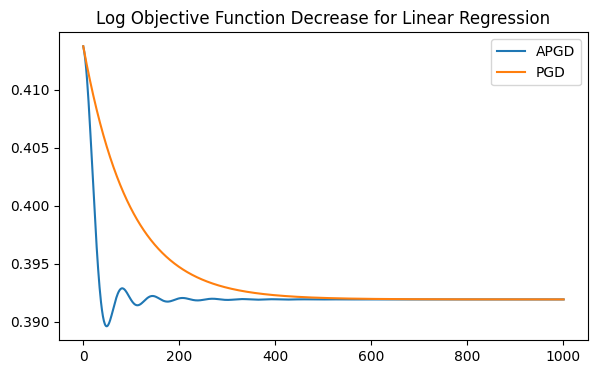

In [70]:
plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 2, 1)
plt.plot(np.log(obj_apgd), label='APGD')
plt.plot(np.log(obj_pgd), label='PGD')
plt.legend()
plt.title('Log Objective Function Decrease for Linear Regression')

Text(0.5, 1.0, 'Log Error Decrease for Linear Regression')

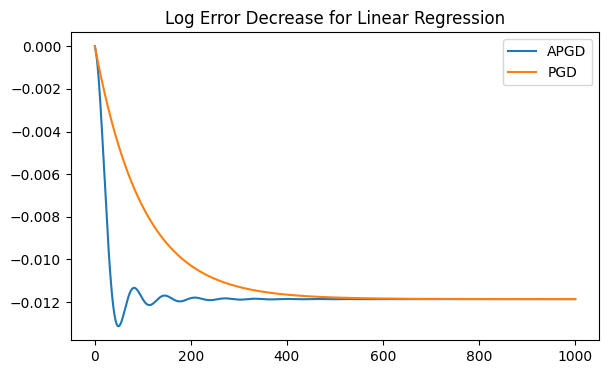

In [71]:
plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 2, 1)
plt.plot(np.log(err_apgd), label='APGD')
plt.plot(np.log(err_pgd), label='PGD')
plt.legend()
plt.title('Log Error Decrease for Linear Regression')

We can see that both algorithms have a decrease in the loss and in errors. However, APGD's objective function and error decrease much faster than PGD, but at the expense of more perturbations/ oscillations.

APGD reached the minimum and stabilized near it in around 200 iterations. In comparison, PGD took about 400 iterations to reach the same point. PGD is stable and converges smoothly. However, this is not the case for APGD: although it initially reached the minimum after around 30 iterations, its convergence process is characterized by oscillations, causing it to move away and require around 170 more iterations to stabilize around the minimum.

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with PGD and APGD with the true parameter `coefs` of
  the model. This can be done with 3 `plt.stem` plots. Do this for one problem (linear or logistic), but for both regularizers. Comment.</li>
    <li> Pick one problem (logistic or linear) and regularizer (L1 or L2), and study the influence of the correlation
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>Pick a different problem (logistic or linear) and a different regularization (L1 or L2), and study the influence of the level of  
  penalization ($\lambda$) on the performance of the optimization algorithms. Explain. Analyse and explain the behavior of the solution vector when $\lambda$ increases.</li>
    </ul>
</div>

1) Comparison between PGD and APGD with the true parameters.

In [94]:
## Question 1 - Linear Regression with L1 and L2
x_apgd_l1, obj_apgd_l1, err_apgd_l1 = APGD(x0, loss_linreg, grad_linreg, L1_norm, prox_L1, step=step, lmbd=0.0001, n_iter=1000)
x_apgd_l2, obj_apgd_l2, err_apgd_l2 = APGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, step=step, lmbd=0.0001, n_iter = 1000)

Lauching APGD solver...
   it    |   obj    |   err   
       0 | 1.53e+00 | 1.00e+00
      10 | 1.53e+00 | 1.00e+00
      20 | 1.52e+00 | 9.99e-01
      30 | 1.52e+00 | 9.97e-01
      40 | 1.51e+00 | 9.95e-01
      50 | 1.50e+00 | 9.93e-01
      60 | 1.49e+00 | 9.90e-01
      70 | 1.48e+00 | 9.87e-01
      80 | 1.47e+00 | 9.84e-01
      90 | 1.46e+00 | 9.80e-01
     100 | 1.45e+00 | 9.77e-01
     110 | 1.43e+00 | 9.73e-01
     120 | 1.42e+00 | 9.70e-01
     130 | 1.41e+00 | 9.66e-01
     140 | 1.40e+00 | 9.63e-01
     150 | 1.39e+00 | 9.60e-01
     160 | 1.38e+00 | 9.57e-01
     170 | 1.37e+00 | 9.54e-01
     180 | 1.36e+00 | 9.51e-01
     190 | 1.36e+00 | 9.48e-01
     200 | 1.35e+00 | 9.46e-01
     210 | 1.35e+00 | 9.44e-01
     220 | 1.34e+00 | 9.42e-01
     230 | 1.34e+00 | 9.41e-01
     240 | 1.33e+00 | 9.39e-01
     250 | 1.33e+00 | 9.38e-01
     260 | 1.33e+00 | 9.37e-01
     270 | 1.33e+00 | 9.36e-01
     280 | 1.32e+00 | 9.35e-01
     290 | 1.32e+00 | 9.35e-01
     300 | 1.32

In [95]:
x_pgd_l1, obj_pgd_l1, err_pgd_l1 = PGD(x0, loss_linreg, grad_linreg, L1_norm, prox_L1, step=step, lmbd=0.0001, n_iter=1000)
x_pgd_l2, obj_pgd_l2, err_pgd_l2 = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, step=step, lmbd=0.0001, n_iter=1000)

Lauching PGDsolver...
   it    |   obj    |   err   
       0 | 1.53e+00 | 1.00e+00
      10 | 1.53e+00 | 1.00e+00
      20 | 1.53e+00 | 1.00e+00
      30 | 1.53e+00 | 9.99e-01
      40 | 1.52e+00 | 9.99e-01
      50 | 1.52e+00 | 9.99e-01
      60 | 1.52e+00 | 9.99e-01
      70 | 1.52e+00 | 9.99e-01
      80 | 1.52e+00 | 9.98e-01
      90 | 1.52e+00 | 9.98e-01
     100 | 1.52e+00 | 9.98e-01
     110 | 1.52e+00 | 9.98e-01
     120 | 1.52e+00 | 9.97e-01
     130 | 1.52e+00 | 9.97e-01
     140 | 1.52e+00 | 9.97e-01
     150 | 1.52e+00 | 9.97e-01
     160 | 1.52e+00 | 9.97e-01
     170 | 1.51e+00 | 9.96e-01
     180 | 1.51e+00 | 9.96e-01
     190 | 1.51e+00 | 9.96e-01
     200 | 1.51e+00 | 9.96e-01
     210 | 1.51e+00 | 9.96e-01
     220 | 1.51e+00 | 9.96e-01
     230 | 1.51e+00 | 9.95e-01
     240 | 1.51e+00 | 9.95e-01
     250 | 1.51e+00 | 9.95e-01
     260 | 1.51e+00 | 9.95e-01
     270 | 1.51e+00 | 9.95e-01
     280 | 1.51e+00 | 9.94e-01
     290 | 1.51e+00 | 9.94e-01
     300 | 1.51e+

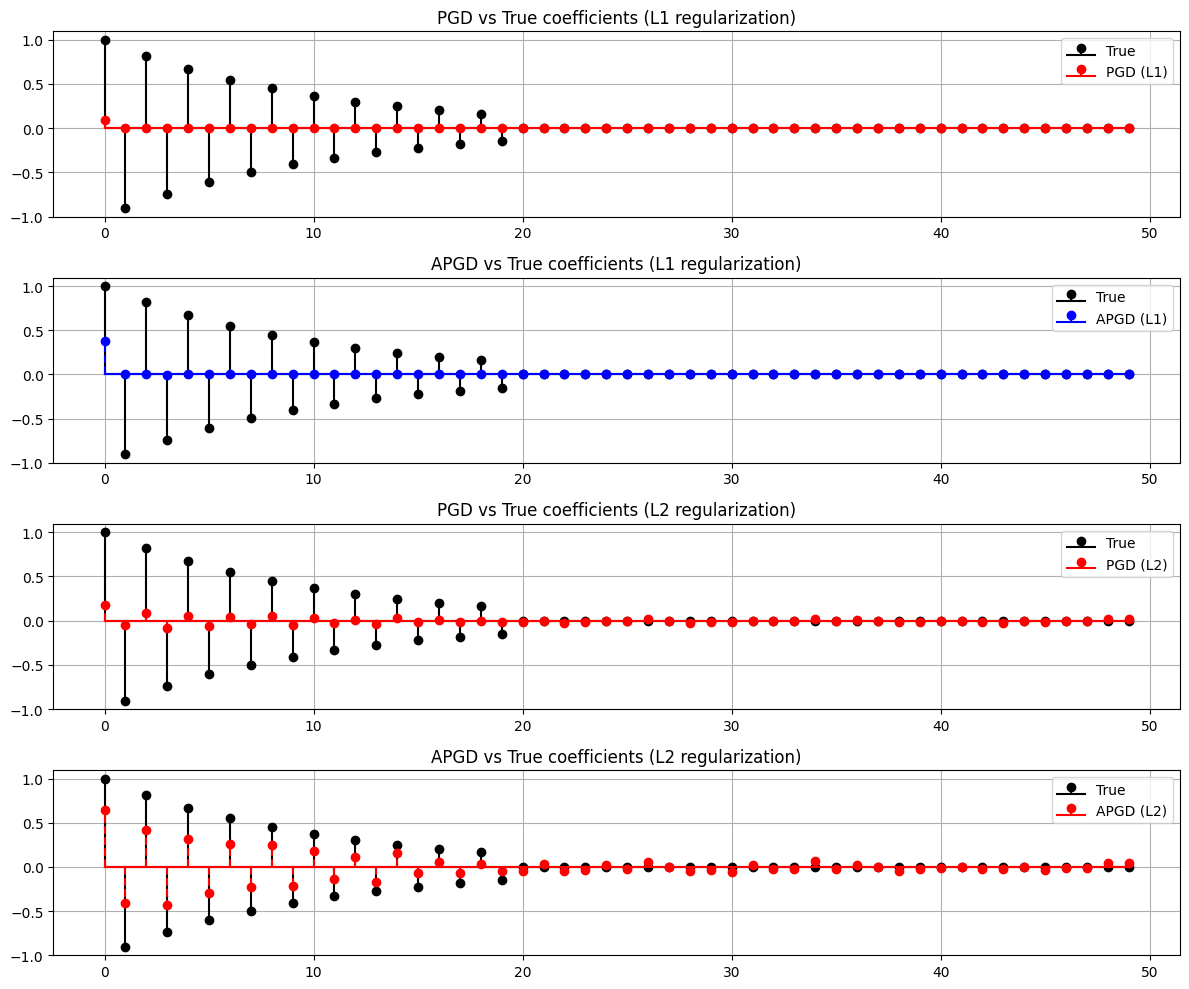

In [97]:
x_true= coefs
plt.figure(figsize=(12, 10))

# ---- 1. True vs PGD (L1 regularization)
plt.subplot(4, 1, 1)
plt.stem(x_true, linefmt='k-', markerfmt='ko', basefmt='k', label='True')
plt.stem(x_pgd_l1, linefmt='r--', markerfmt='ro', basefmt='r', label='PGD (L1)')
plt.title("PGD vs True coefficients (L1 regularization)")
plt.legend()
plt.grid(True)

# ---- 2. True vs APGD (L1 regularization)
plt.subplot(4, 1, 2)
plt.stem(x_true, linefmt='k-', markerfmt='ko', basefmt='k', label='True')
plt.stem(x_apgd_l1, linefmt='b--', markerfmt='bo', basefmt='b', label='APGD (L1)')
plt.title("APGD vs True coefficients (L1 regularization)")
plt.legend()
plt.grid(True)

# ---- 3. Comparison for L2 regularization
plt.subplot(4, 1, 3)
plt.stem(x_true, linefmt='k-', markerfmt='ko', basefmt='k', label='True')
plt.stem(x_pgd_l2, linefmt='r--', markerfmt='ro', basefmt='r', label='PGD (L2)')
plt.title("PGD vs True coefficients (L2 regularization)")
plt.legend()
plt.grid(True)

plt.subplot(4, 1, 4)
plt.stem(x_true, linefmt='k-', markerfmt='ko', basefmt='k', label='True')
plt.stem(x_apgd_l2, linefmt='r--', markerfmt='ro', basefmt='r', label='APGD (L2)')
plt.title("APGD vs True coefficients (L2 regularization)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

We can say the following:
- The regularization term shrinks the coefficients a lot. We will comment on this later on.
- L1 norm promotes sparse solutions. With the regularization affecting a lot the solution, we are finding ourselves left with a coefficient vector of 0. This means that the regularization function is dominating.
- L2 norm affects also our solution but doesn't promote zero coefficients. That's why we can see that the coefficients are slightly better but the coefficients that should be zero are not.
- APGS has better results than PGD, and we showed before that the first one is better. However, we expect that for a higher number of iterations, we should see the same results.

2) Effect of Correlation between features on the L2 Linear Regression (Ridge)

In [122]:
from typing import List
## Linear Regression with L2 and effect of features

def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model

    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model

    n_samples : `int`, default=1000
        Number of samples to simulate

    corr : `float`, default=0.5
         Correlation between features i and j is corr^|i - j|


    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian
        vector with covariance given by the Toeplitz matrix

    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + np.random.randn(n_samples)
    return A, b

List_corr = np.arange( -1, 1.1, 0.1)
error_pgd = []
error_apgd = []

for cor in List_corr :
  A, b = simu_linreg(coefs, corr = cor)
  step = 1/smoothness_const_linreg(A)
  x_apgd_l2, obj_apgd_l2, err_apgd_l2 = APGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, step=step, lmbd=0.0001, n_iter=600)
  x_pgd_l1, obj_pgd_l1, err_pgd_l2 = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, step=step, lmbd=0.0001, n_iter=600)
  error_pgd.append(err_pgd_l2[-1])
  error_apgd.append(err_apgd_l2[-1])



Lauching APGD solver...
   it    |   obj    |   err   
       0 | 4.22e+01 | 1.00e+00
      10 | 4.04e+01 | 9.93e-01
      20 | 3.67e+01 | 9.79e-01
      30 | 3.16e+01 | 9.60e-01
      40 | 2.58e+01 | 9.38e-01
      50 | 1.98e+01 | 9.15e-01
      60 | 1.43e+01 | 8.92e-01
      70 | 9.62e+00 | 8.73e-01
      80 | 5.98e+00 | 8.58e-01
      90 | 3.42e+00 | 8.47e-01
     100 | 1.82e+00 | 8.40e-01
     110 | 9.59e-01 | 8.36e-01
     120 | 5.90e-01 | 8.34e-01
     130 | 4.89e-01 | 8.34e-01
     140 | 4.91e-01 | 8.34e-01
     150 | 5.03e-01 | 8.34e-01
     160 | 4.96e-01 | 8.34e-01
     170 | 4.85e-01 | 8.34e-01
     180 | 4.99e-01 | 8.34e-01
     190 | 5.65e-01 | 8.34e-01
     200 | 6.89e-01 | 8.35e-01
     210 | 8.57e-01 | 8.35e-01
     220 | 1.04e+00 | 8.36e-01
     230 | 1.20e+00 | 8.37e-01
     240 | 1.30e+00 | 8.37e-01
     250 | 1.34e+00 | 8.38e-01
     260 | 1.31e+00 | 8.37e-01
     270 | 1.22e+00 | 8.37e-01
     280 | 1.11e+00 | 8.37e-01
     290 | 9.82e-01 | 8.36e-01
     300 | 8.67

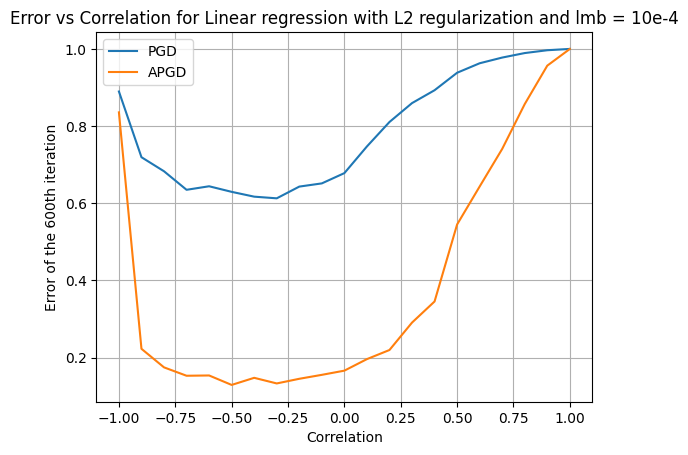

In [123]:
plt.plot(List_corr, error_pgd, label='PGD')
plt.plot(List_corr, error_apgd, label='APGD')
plt.xlabel('Correlation')
plt.ylabel('Error of the 600th iteration')
plt.title('Error vs Correlation for Linear regression with L2 regularization and lmb = 10e-4')
plt.grid()
plt.legend()
plt.show()

The correlation between features has a significant impact on the convergence behavior of both PGD and APGD. When the features are weakly correlated (correlation close to zero), the matrix A is well-conditioned, and both algorithms converge efficiently. In this regime, APGD achieves a much lower error than PGD in fewer iterations, as expected from its accelerated nature.

As the correlation between features increases (toward ±1), the problem becomes ill-conditioned and we're dealing with multi-collinearity: some directions in the loss surface become nearly flat, which slows down convergence. We observe then a higher error with both algorithms

3) Effect of the regularization parameter on L1 Logistic Regression

In [98]:
## Logistic with L1 and the effect of lambda
A, b = simu_logreg(coefs)
step = 1/smoothness_const_loreg(A)

Lauching APGD solver...
   it    |   obj    |   err   
       0 | 6.43e-01 | 9.16e-01
      10 | 4.97e-01 | 3.33e-01
      20 | 4.91e-01 | 3.95e-01
      30 | 4.91e-01 | 3.74e-01
      40 | 4.91e-01 | 3.49e-01
      50 | 4.91e-01 | 3.59e-01
      60 | 4.91e-01 | 3.65e-01
      70 | 4.91e-01 | 3.59e-01
      80 | 4.91e-01 | 3.58e-01
      90 | 4.91e-01 | 3.62e-01
     100 | 4.91e-01 | 3.61e-01
     110 | 4.91e-01 | 3.59e-01
     120 | 4.91e-01 | 3.60e-01
     130 | 4.91e-01 | 3.61e-01
     140 | 4.91e-01 | 3.60e-01
     150 | 4.91e-01 | 3.60e-01
     160 | 4.91e-01 | 3.60e-01
     170 | 4.91e-01 | 3.60e-01
     180 | 4.91e-01 | 3.60e-01
     190 | 4.91e-01 | 3.60e-01
     200 | 4.91e-01 | 3.60e-01
     210 | 4.91e-01 | 3.60e-01
     220 | 4.91e-01 | 3.60e-01
     230 | 4.91e-01 | 3.60e-01
     240 | 4.91e-01 | 3.60e-01
     250 | 4.91e-01 | 3.60e-01
     260 | 4.91e-01 | 3.60e-01
     270 | 4.91e-01 | 3.60e-01
     280 | 4.91e-01 | 3.60e-01
     290 | 4.91e-01 | 3.60e-01
     300 | 4.91

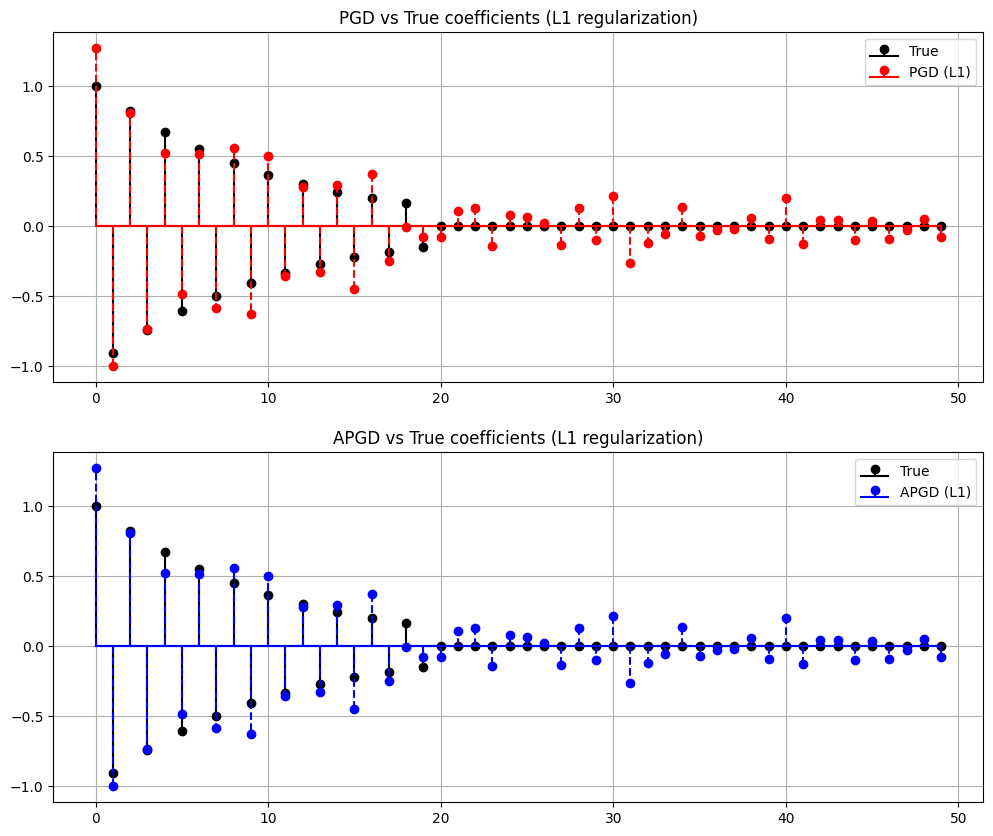

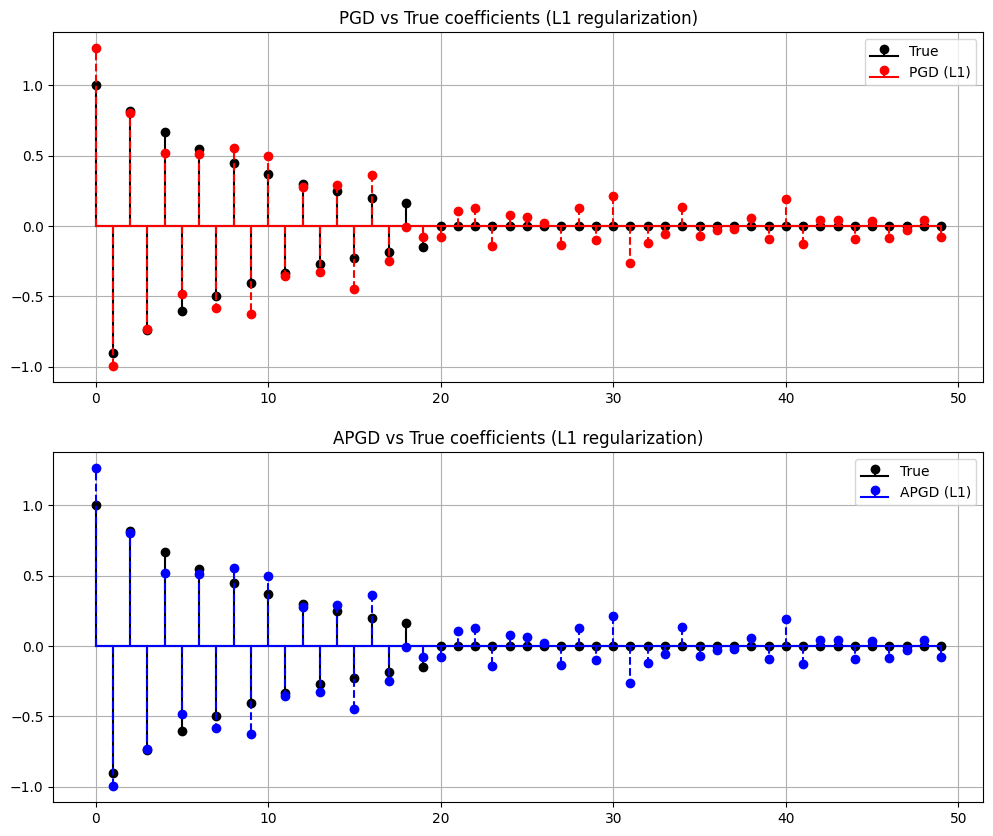

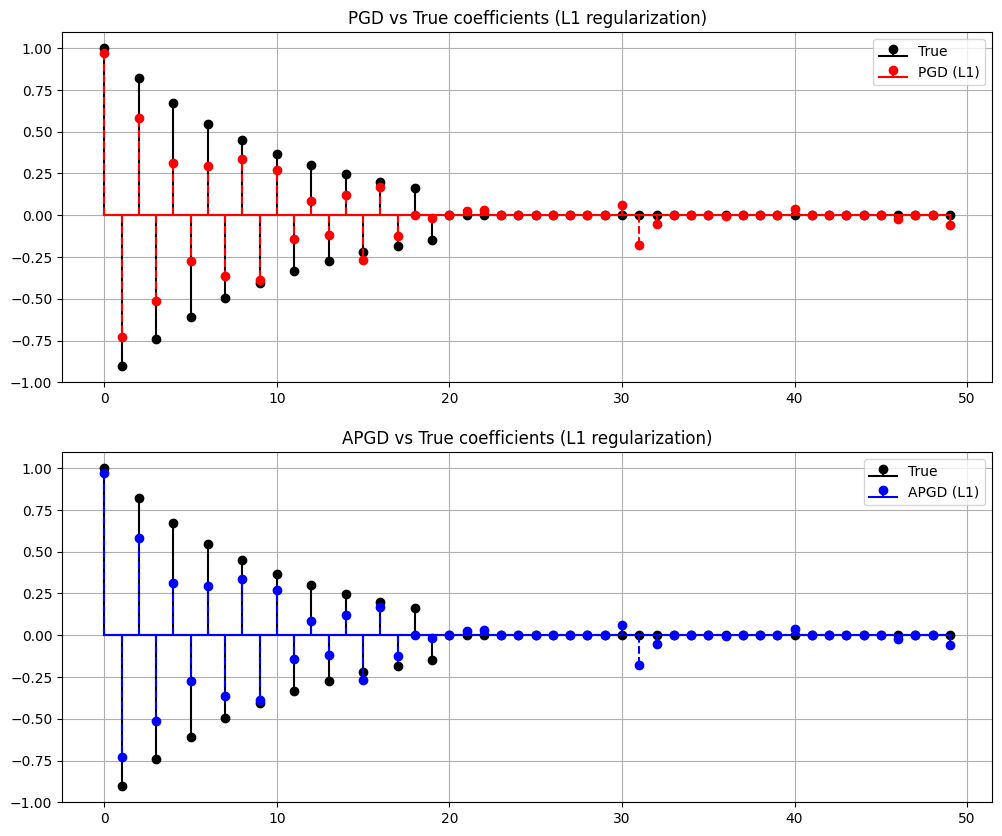

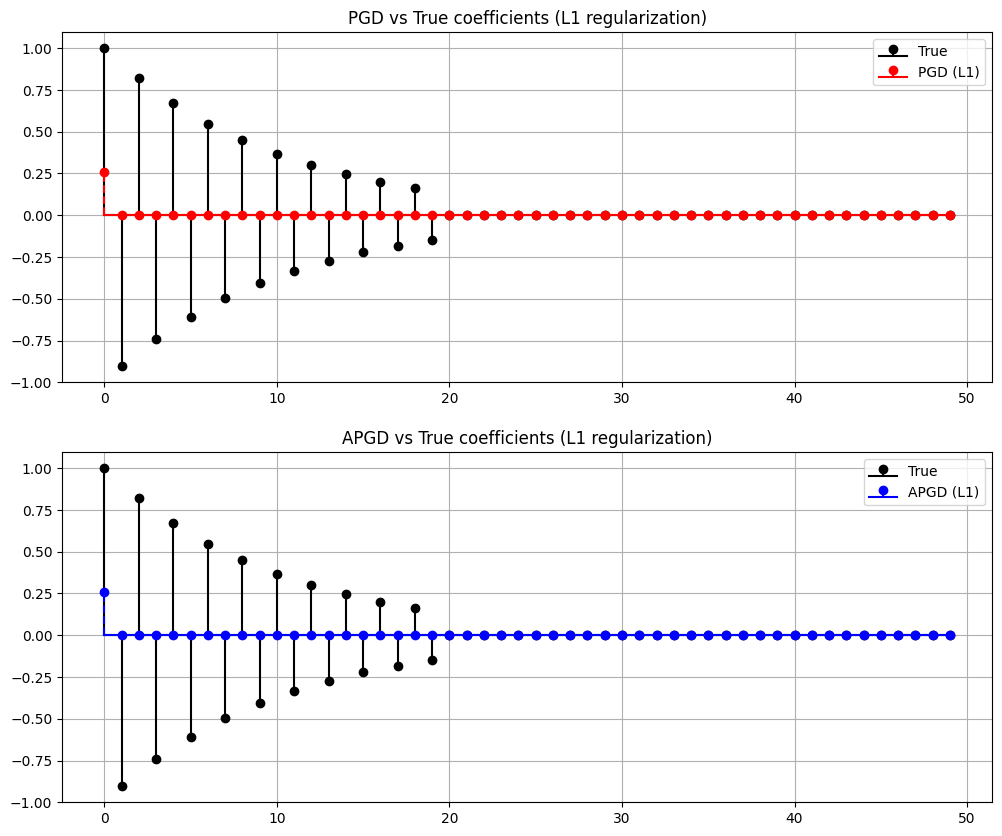

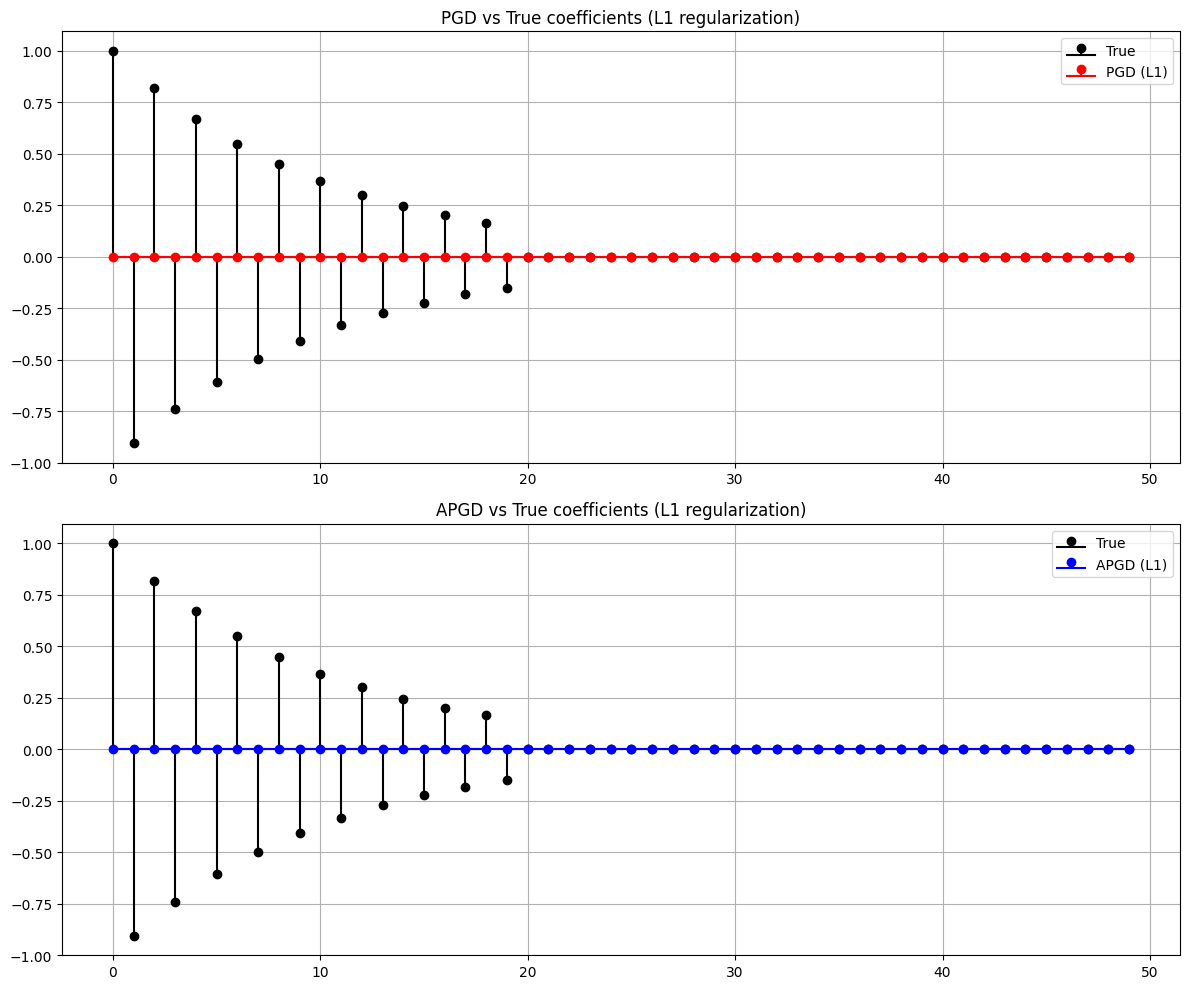

In [100]:
lmbd = [0.0000001, 0.0001, 0.01, 0.1, 1]
error_pgd = []
error_apgd = []
for lmbd in lmbd:

  x_apgd_l1, obj_apgd_l1, err_apgd_l1 = APGD(x0, loss_logreg, grad_logreg, L1_norm, prox_L1, step=step, lmbd=lmbd, n_iter=1000)
  x_pgd_l1, obj_pgd_l1, err_pgd_l1 = PGD(x0, loss_logreg, grad_logreg, L1_norm, prox_L1, step=step, lmbd=lmbd, n_iter=1000)
  error_pgd.append(err_pgd_l1[-1])
  error_apgd.append(err_apgd_l1[-1])
  plt.figure(figsize=(12, 10))

  # ---- 1. True vs PGD (L1 regularization)
  plt.subplot(2, 1, 1)
  plt.stem(coefs, linefmt='k-', markerfmt='ko', basefmt='k', label='True')
  plt.stem(x_pgd_l1, linefmt='r--', markerfmt='ro', basefmt='r', label='PGD (L1)')
  plt.title("PGD vs True coefficients (L1 regularization)")
  plt.legend()
  plt.grid(True)

  # ---- 2. True vs APGD (L1 regularization)
  plt.subplot(2, 1, 2)
  plt.stem(coefs, linefmt='k-', markerfmt='ko', basefmt='k', label='True')
  plt.stem(x_apgd_l1, linefmt='b--', markerfmt='bo', basefmt='b', label='APGD (L1)')
  plt.title("APGD vs True coefficients (L1 regularization)")
  plt.legend()
  plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
##

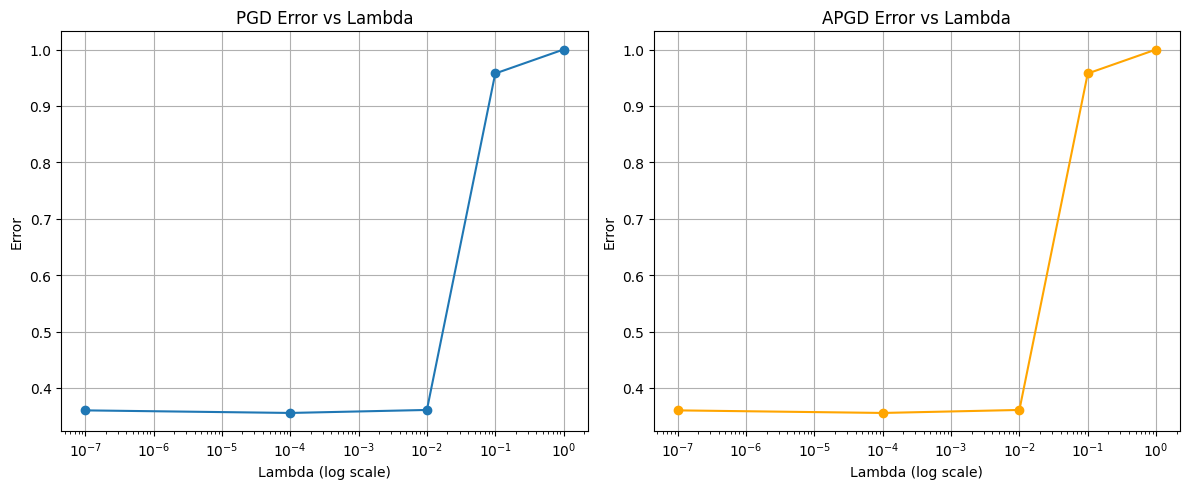

In [104]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot([0.0000001, 0.0001, 0.01, 0.1, 1], error_pgd, marker='o')
plt.xscale('log')
plt.xlabel('Lambda (log scale)')
plt.ylabel('Error')
plt.title('PGD Error vs Lambda')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot([0.0000001, 0.0001, 0.01, 0.1, 1], error_apgd, marker='o', color='orange')
plt.xscale('log')
plt.xlabel('Lambda (log scale)')
plt.ylabel('Error')
plt.title('APGD Error vs Lambda')
plt.grid(True)

plt.tight_layout()
plt.show()

We can realize the following:
- L1 norm generates sparse solutions, so we expect to see coefficients = 0.
- When the regularization term is large, all coefficients are =0 as the regularization function is dominant.
- Howerver, when we decrease the lambda a lot, we see that our solution vector is close to the true one, and also the coefficients that should be = 0 are effectively equal to zero. Though the best solution obtained for lambda = 0.0001 is not perfect, we can see that many coefficients were correctly set to zero.
- Also, APGD has slightly better solutions but is faster as we showed before.

Finally, when we increase the value of lambda, we can see that the error explodes as the L1 norm became dominant and set all coefficients to zero. Also, a very small value for lambda lets the coefficients get bigger, so this hyperparameter should be chosen wisely.